In [69]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
import seaborn as sns
import io
import base64

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import random_split, DataLoader
import tqdm 
import time

**Instruções gerais:** Sua submissão <u>deve</u> conter: 
1. Um "ipynb" com seu código e as soluções dos problemas
2. Uma versão pdf do ipynb

Caso você opte por resolver as questões de "papel e caneta" em um editor de $\LaTeX$ externo, o inclua no final da versão pdf do 'ipynb'--- submetendo um <u>único pdf</u>.

# Trabalho de casa 07: Redução de dimensionalidade

**1.** Considere o conjunto de dados disponível em penguins.csv, organizado em 5
colunas, sendo 4 colunas de atributos e a última a classe do padrão. Os dados
referem-se a medições anatômicas de pinguins da Antártida, classificados nas
espécies Adelie, Chinstrap e Gentoo. Maiores detalhes sobre os dados podem
ser conferidos em https://allisonhorst.github.io/palmerpenguins/.

**a)** Apresente a projeção em 2 dimensões dos padrões acima obtida pelo método PCA (análise dos componentes principais).

**b)** Ainda considerando o item anterior, calcule e mostre a variância explicada obtida quando a dimensão projetada é modificada (1,2,3 ou 4).

Normalize os dados antes de executar PCA. Implemente sua própria versão de PCA, mas verifique a corretude comparando contra alguma implementação popular (e.g., da biblioteca scikitlearn).

In [32]:
# Importando o dataset
data = torch.from_numpy(pd.read_csv("./penguins.csv", header=None).to_numpy())
# Separando os dados em features e labels
X, y = data[:, :-1], data[:, -1].long()
centralized_data = X - X.mean(0, keepdim=True)
normalized_data = centralized_data / X.std(0, keepdim=True)

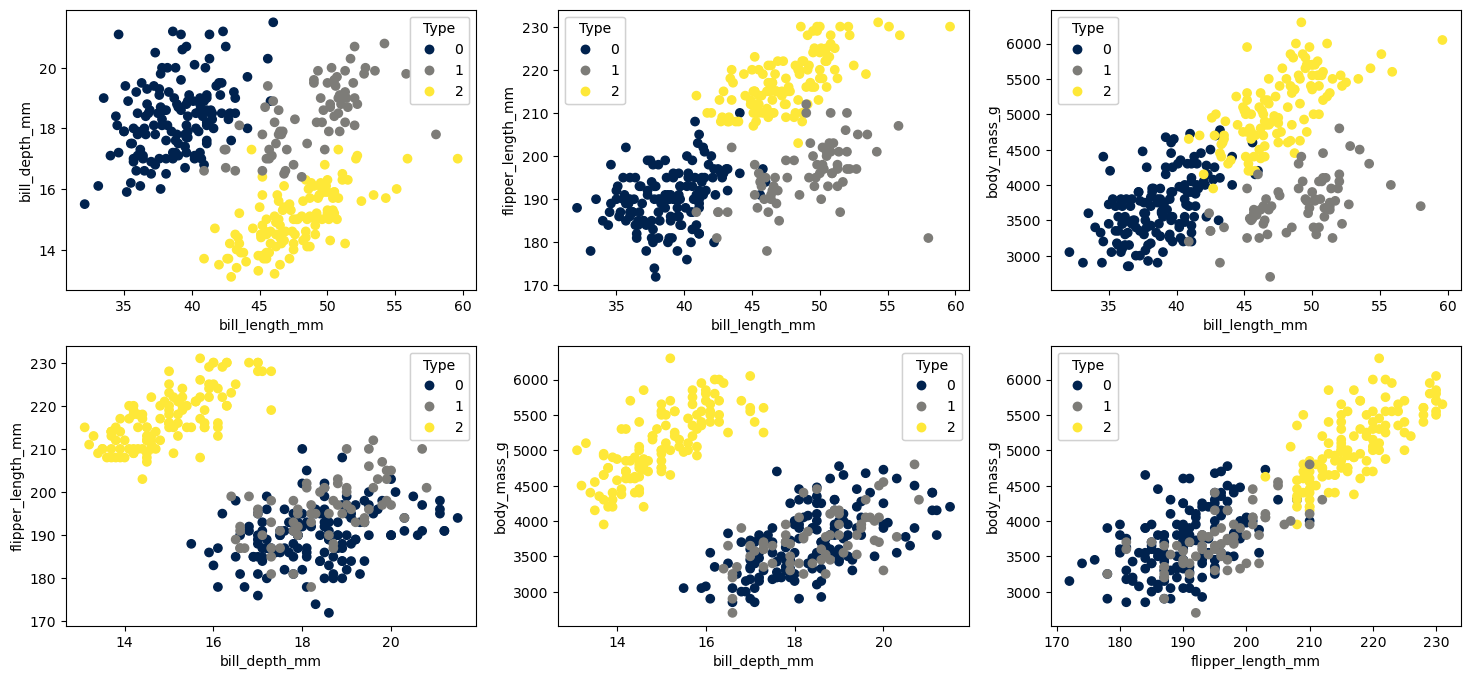

In [33]:
columns = np.array(["bill_length_mm", "bill_depth_mm", "flipper_length_mm", "body_mass_g"])
# Plotting the data for each pair of features
fig, ax = plt.subplots(2, 3, figsize=(18, 8))
ax = ax.flatten()

k = 0    
for i in range(4):
    for j in range(i + 1, 4):
        scatter = ax[k].scatter(X[:, i], X[:, j], c=y, cmap="cividis")
        ax[k].set_xlabel(columns[i])
        ax[k].set_ylabel(columns[j])
        legend = ax[k].legend(*scatter.legend_elements(), title="Type")
        ax[k].add_artist(legend)
        k += 1

In [167]:
# Análise dos Componentes Principais
def PCA_(X: torch.Tensor, n_components: int):
    # Fazendo a decomposição SVD da matriz de dados
    U, D, Vt = torch.linalg.svd(X, full_matrices=False)

    # SVD Flip
    max_abs = torch.abs(U).argmax(0)
    j = torch.arange(U.size()[1]).to(X.device)
    # Acessa as linhas de índice correspondente aos encontrados anteriormente e obtém os sinais
    signs = torch.sign(U[max_abs, j])
    Vt *= signs.view(-1, 1)    # Multiplica por um vetor coluna de sinais

    # Selecionando os n_components autovetores correspondentes aos maiores autovalores
    top_eigenvectors = Vt[:n_components]

    # Projetando os dados nos n_components autovetores
    projected_data = torch.mm(X, top_eigenvectors.T)
    # Calculando a variância explicada
    explained_variance = get_explained_variance(top_eigenvectors)
    return explained_variance, projected_data

def get_explained_variance(top_eigenvectors: torch.Tensor):
    SS = top_eigenvectors**2 # SS is the sum of squares
    explained_variance = SS / SS.sum()
    return explained_variance

def plot_data(ax, X: torch.Tensor, y: torch.Tensor, labels: torch.Tensor, title: str, xlabel: str = None, ylabel: str = None):
    scatter = ax.scatter(x=X, y=y, s=20, c=labels, cmap="cividis")
    legend = ax.legend(*scatter.legend_elements())
    ax.set_title(title)
    ax.add_artist(legend)
    if xlabel:
        ax.set_xlabel(xlabel)
    if ylabel:
        ax.set_ylabel(ylabel)

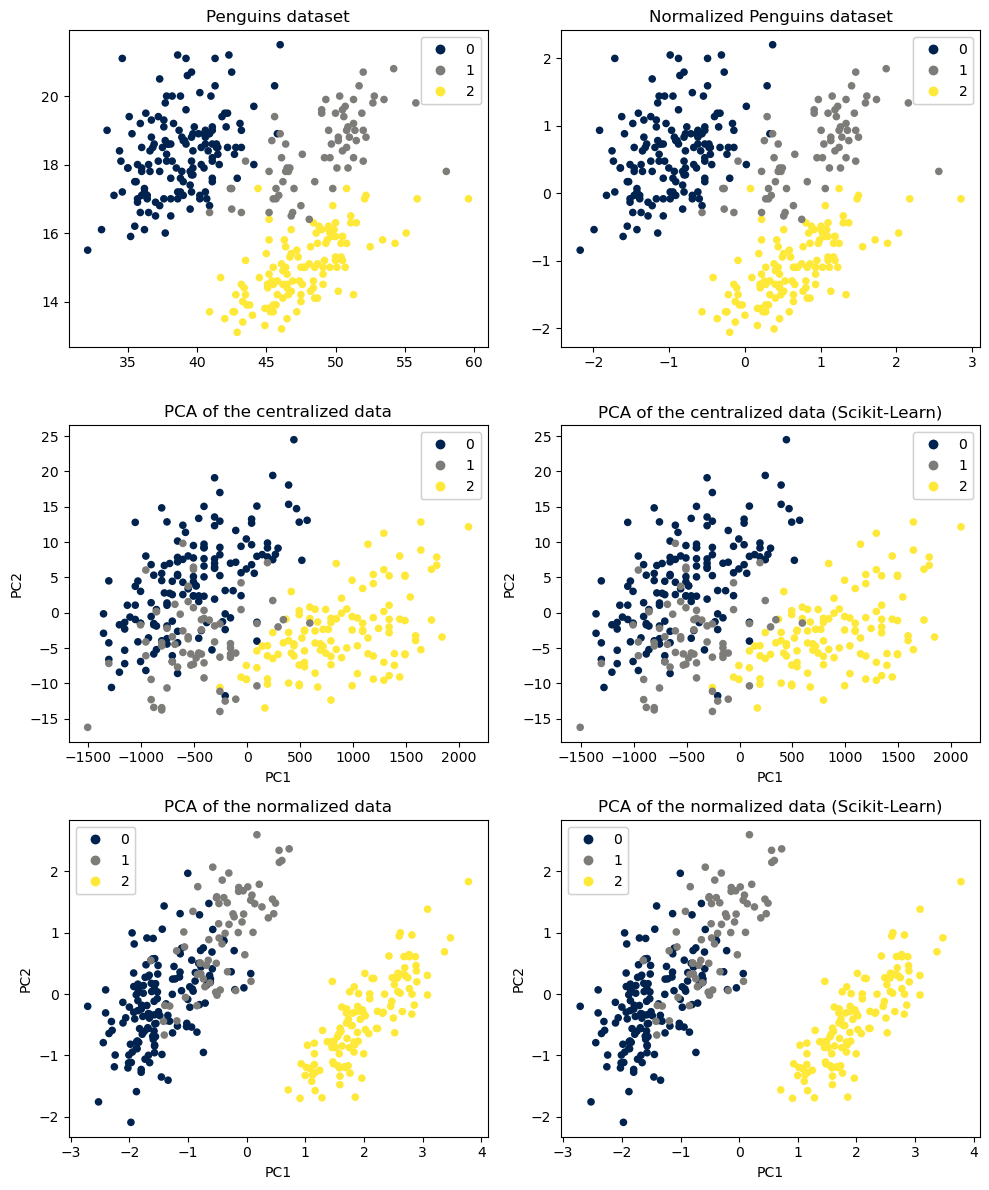

In [166]:
from sklearn.decomposition import PCA as PCA_sklearn

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10, 12))
plot_data(axes[0, 0], X[:, 0], X[:, 1], y, "Penguins dataset") # Visualizing the original data
plot_data(axes[0, 1], normalized_data[:, 0], normalized_data[:, 1], y, "Normalized Penguins dataset")# Visualizing the normalized data

# Visualizing the data projected in 2D (centralized data)
variance, projected_data = PCA_(centralized_data, 2)
plot_data(axes[1, 0], projected_data[:, 0], projected_data[:, 1], y, "PCA of the centralized data", "PC1", "PC2")
# Plot the data projected by scikit-learn's PCA
sklearn_pca = PCA_sklearn(n_components=2)
projected_data1 = sklearn_pca.fit_transform(centralized_data)
plot_data(axes[1, 1], projected_data1[:, 0], projected_data1[:, 1], y, "PCA of the centralized data (Scikit-Learn)", "PC1", "PC2")

# Visualizing the data projected in 2D
variance, projected_data2 = PCA_(normalized_data, 2)
plot_data(axes[2, 0], projected_data2[:, 0], projected_data2[:, 1], y, "PCA of the normalized data", "PC1", "PC2")
# Plot the data projected by scikit-learn's PCA
sklearn_pca = PCA_sklearn(n_components=2)
projected_data3 = sklearn_pca.fit_transform(normalized_data)
plot_data(axes[2, 1], projected_data3[:, 0], projected_data3[:, 1], y, "PCA of the normalized data (Scikit-Learn)", "PC1", "PC2")

plt.tight_layout()
plt.show()

Acima temos a projeção dos dados em 2 dimensões obtida pelo método PCA, pela minha implementação lado a lado com a implementação do Scikit-Learn. Na segunda linha, temos $X$ centralizado (apenas subtraído pela média), e na terceira linha, temos $X$ normalizado (centralizado e dividido pelo desvio padrão). A seguir vamos calcular a variância explicada para cada uma dessas projeções.

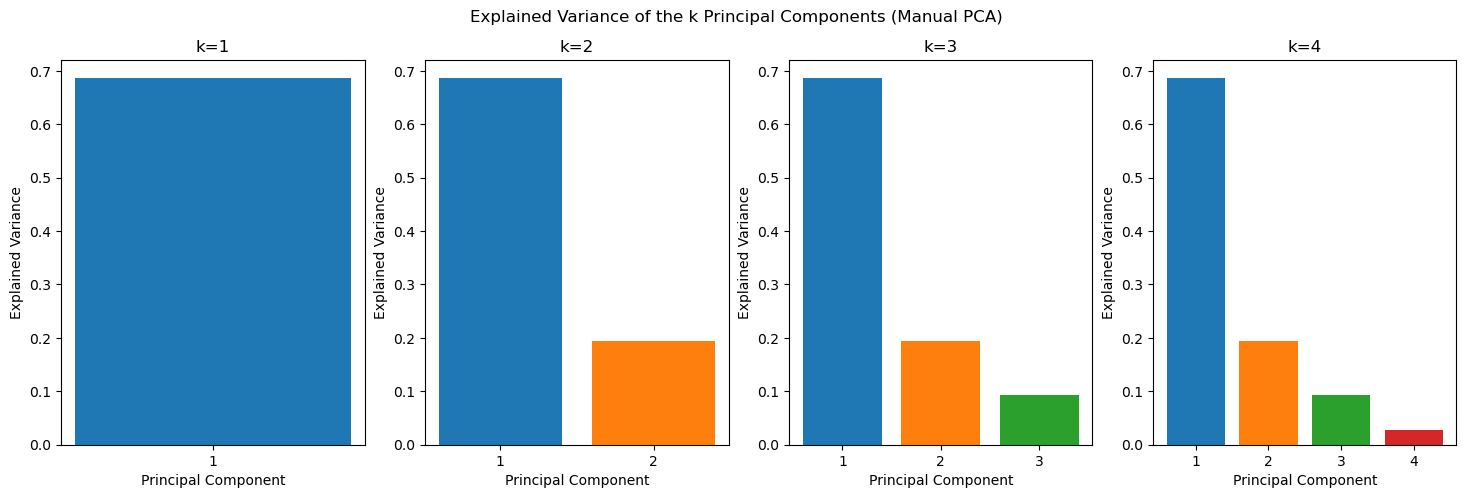

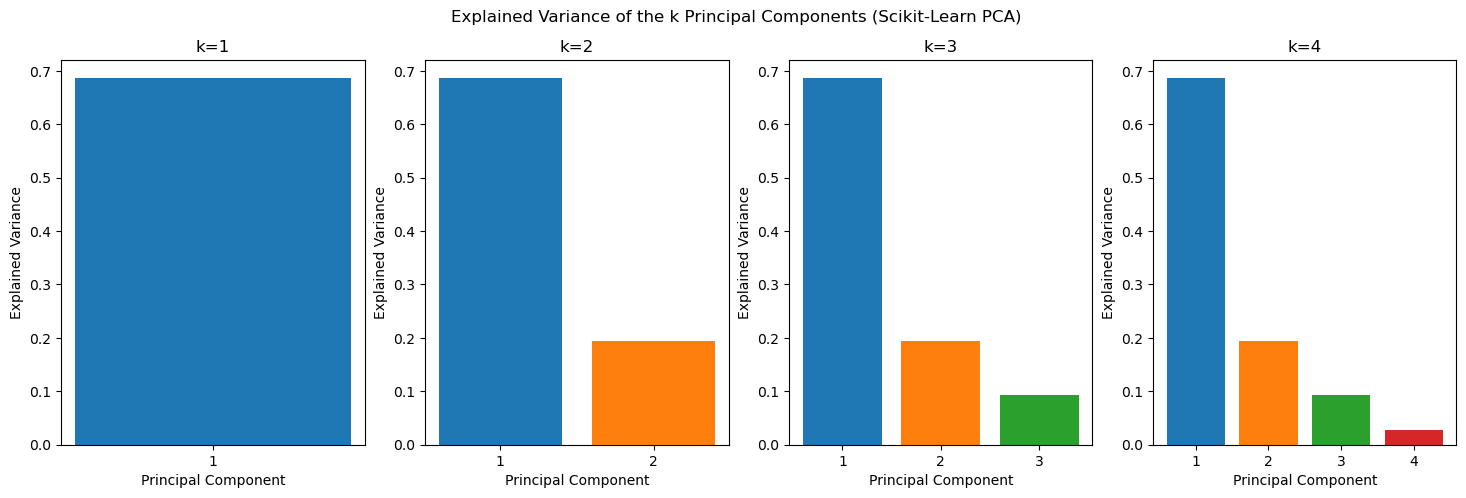

In [48]:
colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf"]
# Plotting the explained variance
def plot_variance(ax, explained_variance: torch.Tensor | np.ndarray, title: str):
    x_ticks = list(range(1, len(explained_variance)+1))
    explained_variance = (explained_variance.numpy() if isinstance(explained_variance, torch.Tensor) else explained_variance)
    ax.bar(x=x_ticks, height=explained_variance, tick_label=x_ticks, color=colors)
    ax.set_title(title)
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Explained Variance")

# Explained Variance - PCA implementation with NORMALIZED data
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(18, 5))
fig.suptitle("Explained Variance of the k Principal Components (Manual PCA)")
for k in range(1, 5):
    variance, _ = PCA_(normalized_data, k)
    plot_variance(axes[k-1], variance, f"k={k}")

# Explained Variance - Scikit-learn's PCA with NORMALIZED data
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(18, 5))
fig.suptitle("Explained Variance of the k Principal Components (Scikit-Learn PCA)")
for k in range(1, 5):
    sklearn_pca = PCA_sklearn(n_components=k)
    projected_data = sklearn_pca.fit_transform(normalized_data.numpy())
    explained_variance = sklearn_pca.explained_variance_ratio_
    plot_variance(axes[k-1], explained_variance, f"k={k}")


**2.** Implemente um autoencoder determinísitco para o banco de dados MNIST, que já usamos em exercícios anteriores. Você pode escolher utilizar tanto CNN como MLP no encoder/decoder. No entanto, o encoder deve mapear as imagens no $\mathbb{R}^2$, para podermos visualizar as representações latentes no plano. Use o conjunto de validação para fazer early stopping. Você também pode monitorar o erro na validação para anelar a taxa de aprendizado (usando um scheduler). Finalmente, mostre a projeção das imagens de teste no espaço latente e comente qualitativamente os embeddings obtidos.

In [74]:
train_val_dataset = datasets.MNIST(
    root="./data",
    train=True,
    download=True,
    transform=transforms.ToTensor(),
)

test_dataset = datasets.MNIST(
    root="./data",
    train=False,
    download=True,
    transform=transforms.ToTensor(),
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [87]:
train_loader = DataLoader(train_val_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

val_dataset, train_dataset = random_split(train_val_dataset, [0.8, 0.2])
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)

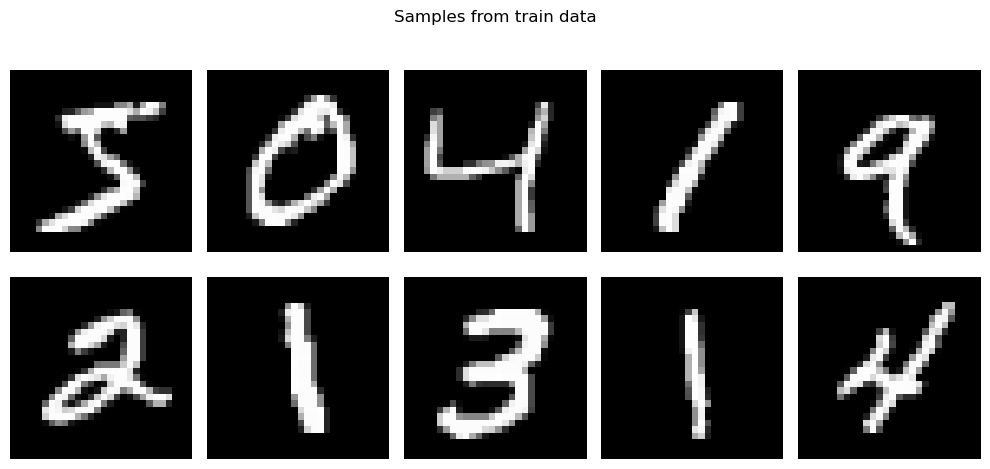

In [107]:
fig, ax = plt.subplots(2,5, figsize=(10,5))
for i in range(10):
    ax[i//5,i%5].imshow(train_val_dataset.data[i], cmap="gray")
    ax[i//5,i%5].axis('off')
fig.suptitle("Samples from train data")
fig.tight_layout()

Vamos criar 3 classes, uma para o encoder, uma para o decoder e uma para o autoencoder. O encoder deve mapear as imagens no $\mathbb{R}^2$, e o decoder deve mapear as imagens de volta para o espaço original. Depois, vamos mostrar a projeção das imagens de teste no espaço latente e comentar qualitativamente os embeddings obtidos.

In [152]:
class Encoder(nn.Module):
    def __init__(self, input_dim: int, hidden_dim: int, z_dim: int):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim//2)
        self.fc3 = nn.Linear(hidden_dim//2, z_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class Decoder(nn.Module):
    def __init__(self, output_dim: int, hidden_dim: int, z_dim: int):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(2, hidden_dim//2)
        self.fc2 = nn.Linear(hidden_dim//2, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x

class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = Encoder(input_dim=784, hidden_dim=128, z_dim=2)
        self.decoder = Decoder(output_dim=784, hidden_dim=128, z_dim=2)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [153]:
# Definindo o modelo, otimizador e parâmetros de treinamento
model = AutoEncoder().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.BCELoss(reduction="sum")
n_epochs = 20
min_val_loss = float("inf")

In [154]:
iterable = tqdm.trange(n_epochs, desc="Época", leave=False)
# Treinamento
for epoch in iterable:
    model.train()
    train_loss = 0
    for batch_features, _ in train_loader:
        batch_features = batch_features.view(-1, 784).to(device)
        optimizer.zero_grad()
        outputs = model(batch_features)
        loss = criterion(outputs, batch_features)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch_features, _ in val_loader:
            batch_features = batch_features.view(-1, 784).to(device)
            outputs = model(batch_features)
            loss = criterion(outputs, batch_features)
            val_loss += loss.item()

    train_loss /= len(train_loader.dataset)
    val_loss /= len(val_loader.dataset)
    iterable.set_postfix(train_loss=train_loss, val_loss=val_loss)

    if val_loss < min_val_loss:
        min_val_loss = val_loss
        torch.save(model.state_dict(), "./model.pth")

In [134]:
# Carregando o modelo treinado
model.load_state_dict(torch.load("./model.pth"))

<All keys matched successfully>

In [155]:
print(f"Final train loss: {train_loss:.4f}")
print(f"Final validation loss: {val_loss:.4f}")

print(f"Average train loss: {train_loss / len(train_loader):.4f}")
print(f"Average validation loss: {val_loss / len(val_loader):.4f}")

Final train loss: 138.2287
Final validation loss: 137.7249
Average train loss: 0.2947
Average validation loss: 0.3673


Agora vamos mostrar algumas imagens reconstruídas pelo autoencoder.

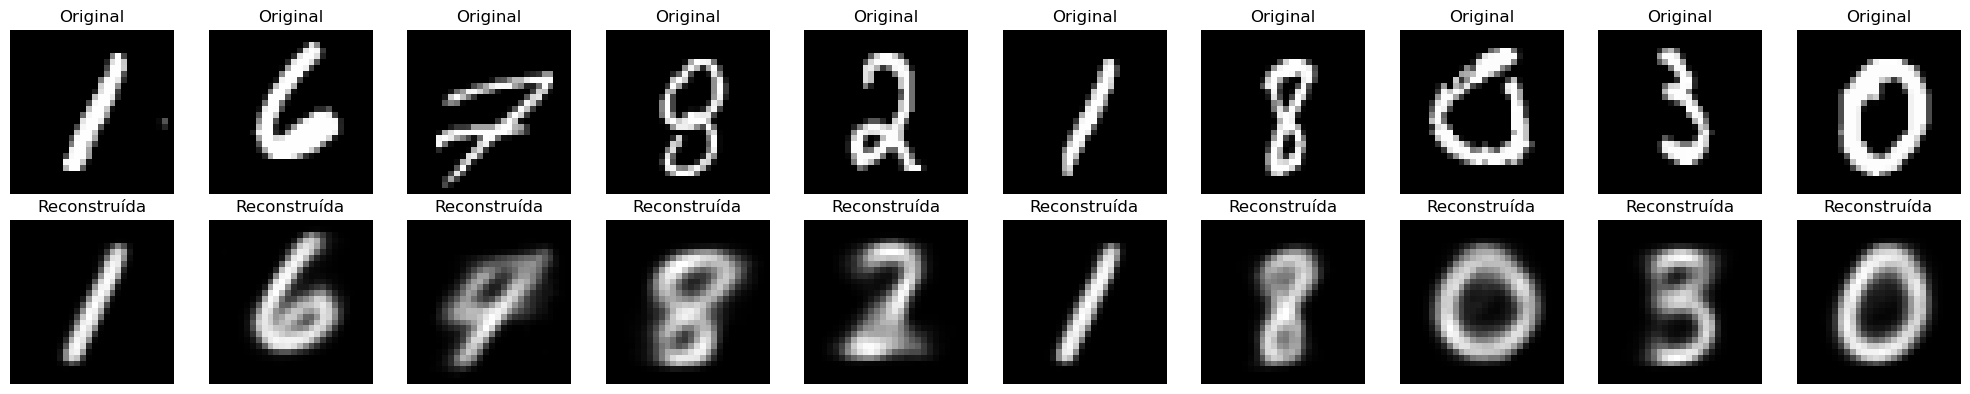

In [161]:
with torch.no_grad():
    model.load_state_dict(torch.load("./model.pth"))
    model.eval()

    # escolhe 10 amostras no conjunto de teste
    idx = np.random.choice(len(test_dataset), 10)
    test_samples = torch.stack([test_dataset[i][0] for i in idx])
    test_samples = test_samples.view(-1, 784).to(device)
    reconstructed_samples = model(test_samples)
    reconstructed_samples = reconstructed_samples.view(-1, 1, 28, 28).cpu()

    # plotar as imagens originais e reconstruídas
    fig, axes = plt.subplots(nrows=2, ncols=10, figsize=(20, 4))
    for images, row, title in zip([test_samples, reconstructed_samples], axes, ["Original", "Reconstruída"]):
        for img, ax in zip(images, row):
            ax.imshow(img.view(28, 28).numpy(), cmap="gray")
            ax.axis("off")
            ax.set_title(title)
    plt.tight_layout()
    plt.show()

Agora só nos resta projetar as imagens de teste no espaço latente. Para isso, vamos criar uma função que recebe um autoencoder e um conjunto de imagens e retorna as projeções dessas imagens.

In [162]:
def plot_2d_latent_space(model, loader):
    model.eval()
    with torch.no_grad():
        latent_vectors = []
        labels = []
        for batch_features, batch_labels in loader:
            batch_features = batch_features.view(-1, 784).to(device)
            x = model.encoder(batch_features)
            latent_vectors.append(x)
            labels.append(batch_labels.cpu())

        latent_vectors = torch.cat(latent_vectors, dim=0).cpu()
        labels = torch.cat(labels, dim=0).numpy()

    fig, ax = plt.subplots(figsize=(8, 6))
    scatter = ax.scatter(latent_vectors[:, 0], latent_vectors[:, 1], c=labels, cmap="tab10")
    legend = ax.legend(*scatter.legend_elements(), title="Digit")
    ax.add_artist(legend)


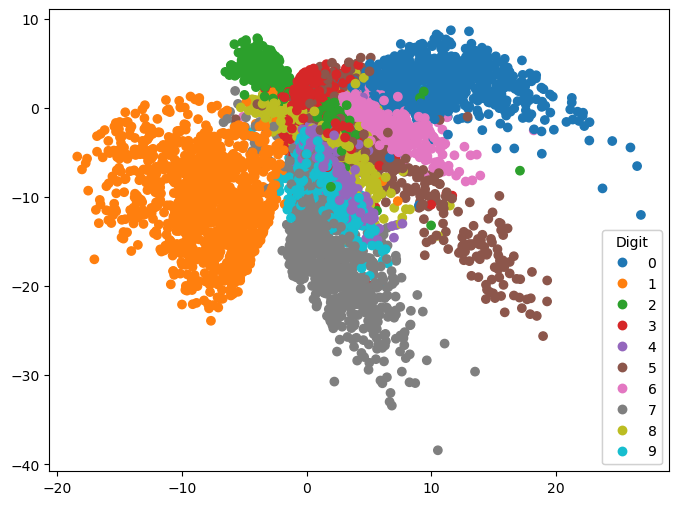

In [158]:
plot_2d_latent_space(model, test_loader)

Podemos ver que as imagens com mesmo label estão bem agrupadas, então a projeção das imagens de teste no espaço latente parece ter sido feita de forma correta. 